# Models with `body`
#### Making models based only off the comment.

##### TABLE OF CONTENTS
 - [Observations and Overview for Models with `body`](#Observations-and-Overview-for-Models-with-body)
 - [Import and Define our Variables for Models with `body`](#Import-and-Define-our-Variables-for-Models-with-body)
 - [Logistic Regression Models with `body`](#Logistic-Regression-Models-with-body)
 - [Random Forest Models with `body`](#Random-Forest-Models-with-body)
 - [Decision Tree Models with `body`](#Decision-Tree-Models-with-body)
 - [Gradient Boosting Models with `body`](#Gradient-Boosting-Models-with-body)
 - [Bagging Classifier Models with `body`](#Bagging-Classifier-Models-with-body)
 - [Ada Boosting Models with `body`](#Ada-Boosting-Models-with-body)
 - [Compare Models with `body`](#Compare-Models-with-body)


### Observations and Overview for Models with `body`
[(back to top)](#Models-with-body) <br />

From my basic models in [03 - Models with GridSearch](03_models_with_gridsearch.ipynb) I wanted to try getting better results. I am embarrassed to say this is the part where I actually did a thorough cleaning of my data. But I wanted to get some perspective of what I was dealing with before cleaning. And it is worth noting that I had to go back and clean up and organize the previous notebook so I could make sense of how my models were performing more easily.

So I imported my 'clean_data.csv' file into this Notebook, and I Was ready to explore more than just Logistic Regression, KNN Classifier, and Naive Bayes. But since Logistic Regression performed best in the previous Notebook, I added it to this one for comparison.

Testing Random Forest, Decision Tree, and Bagging classifiers gave me a lot of overfitting, but the resulting scores were inline with all other scores I was getting (F1 Scores: for  __0.634424__ Random Forest, and __0.668405__ for Decision Tree, and __0.610572__ for the Bagging Classifier)

The Gradient Boosting and Ada Boosting did not overfit as badly, but were biased. The Gradient Boosting Classifier was biased towards 'AskReddit' while the Ada Boosting Classifier was biased towards the AMA subreddit. (F1 Scores: for  __0.660985__ Gradient Boosting, and __0.647233__ for Ada Boosting)

And as we know from the previous Notebook, Logistic Regression has a slight bias towards 'AskReddit', and an F1 Score of __0.679302__ (Best accuracy score from gridsearch is 0.7138).


### Import and Define our Variables for Models with `body`
[(back to top)](#Models-with-body) <br />


In [1]:
from ipynb.fs.full.functions import *

In [2]:
# Data to create our model
df = pd.read_csv('../data/clean_data.csv')
df = add_binary_and_drop(df, drop='subreddit', repl_w_zero='AMA')
df = remove_keywords(df, col_to_modify='body', remove_from='AMA')
df = remove_keywords(df, col_to_modify='body', remove_from='AskReddit')
df = remove_deleted_comments(df, col_to_modify='body', repl_w_nan='[deleted]')

In [3]:
# Model X, and y

X = df['body']
y = df['subreddit_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=3)

In [4]:
# TEST data (not part of train/test/split)
df1 = pd.read_csv('../data/2021-04-27_1812_AMA_comments.csv')
df2 = pd.read_csv('../data/2021-04-27_1812_AskReddit_comments.csv')
df_test_pred = pd.concat([df1, df2], axis=0)

In [5]:
df_test_pred = drop_cols_cleaning(df_test_pred)
df_test_pred = add_binary_and_drop(df_test_pred, drop='subreddit', repl_w_zero='AMA')

In [6]:
df_test_pred = remove_keywords(df_test_pred, col_to_modify='body', remove_from='AMA')
df_test_pred = remove_keywords(df_test_pred, col_to_modify='body', remove_from='AskReddit')
df_test_pred = remove_deleted_comments(df_test_pred, col_to_modify='body', repl_w_nan='[deleted]')
df_test_pred.shape


(1930, 8)

In [7]:
df_test_pred = df_test_pred.sample(n=df_test_pred.shape[0], random_state=3)

X_new = df_test_pred['body']
y_new = df_test_pred['subreddit_binary'] 

## Logistic Regression Models with `body`
[(back to top)](#Models-with-body) <br />


<h2> (gridsearch) CountVectorizer(), LogisticRegression() </h2>


In [8]:
gs_cv_lgr = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    LogisticRegression()), 
    X_train, X_test, y_train, y_test,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test cVect LogReg')



Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [9]:
print(gs_cv_lgr.model.best_score_)
print(gs_cv_lgr.model.best_estimator_)

0.7052590909517684
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('logisticregression', LogisticRegression())])


In [10]:
X_gs_cv_lgr = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    LogisticRegression()), 
    X, X_new, y, y_new,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new cVect LogReg')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [11]:
print(X_gs_cv_lgr.model.best_score_)
print(X_gs_cv_lgr.model.best_estimator_)

0.6989007253365258
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('logisticregression', LogisticRegression())])


<h2 style="color:red;"> (gridsearch) TfidfVectorizer(), LogisticRegression() </h2>
<h2 style="color:red;"> BEST! F1 score: 71.16% </h2>
(see DataFrame below)

In [12]:

gs_tv_lgr = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    LogisticRegression()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf LogReg')



Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [13]:
print(gs_tv_lgr.model.best_score_)
print(gs_tv_lgr.model.best_estimator_)

0.7137560911489386
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('logisticregression', LogisticRegression())])


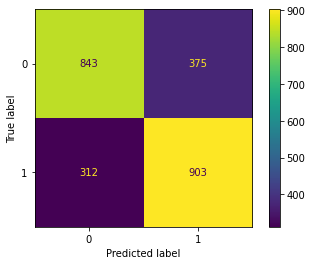

In [14]:
plot_confusion_matrix(gs_tv_lgr.model, X_test, y_test)

In [15]:
X_gs_tv_lgr = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    LogisticRegression()), 
    X_train=X, X_test=X_new, y_train=y, y_test=y_new,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new Tfidf LogReg')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [16]:
print(X_gs_tv_lgr.model.best_score_)
print(X_gs_tv_lgr.model.best_estimator_)

0.71102542135343
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('logisticregression', LogisticRegression())])


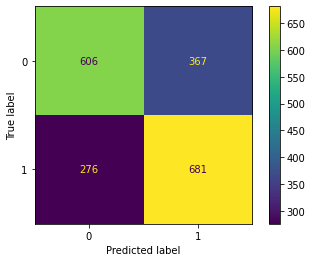

In [17]:
plot_confusion_matrix(X_gs_tv_lgr.model, X_new, y_new)

In [18]:
compare_lgr = pd.concat([gs_cv_lgr.df, X_gs_cv_lgr.df, gs_tv_lgr.df, X_gs_tv_lgr.df], axis=1)
compare_lgr

,Train/Test cVect LogReg,Xy/new cVect LogReg,Train/Test Tfidf LogReg,Xy/new Tfidf LogReg
F1 Score,0.724341,0.650980,0.724428,0.679302
Recall Score,0.758025,0.693835,0.743210,0.711599
Accuracy,0.711878,0.631088,0.717633,0.666839
Balanced Accuracy,0.711935,0.631604,0.717664,0.667207
Precision Score,0.693524,0.613112,0.706573,0.649809
Average Precision Score,0.757351,0.664860,0.790564,0.707293
ROC AUC Score,0.780030,0.696882,0.798083,0.735097
True Positive,811.000000,554.000000,843.000000,606.000000
False Negative,407.000000,419.000000,375.000000,367.000000
False Positive,294.000000,293.000000,312.000000,276.000000


## Random Forest Models with `body`
[(back to top)](#Models-with-body) <br />


<h2> (gridsearch) CountVectorizer(), RandomForestClasifier() </h2>


In [19]:
gs_cv_rfc = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    RandomForestClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test cVect RFC')



Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [20]:
print(gs_cv_rfc.model.best_score_)
print(gs_cv_rfc.model.best_estimator_)

0.6934766728947392
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('randomforestclassifier', RandomForestClassifier())])


In [21]:
X_gs_cv_rfc = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    RandomForestClassifier()), 
    X, X_new, y, y_new,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new cVect RFC')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [22]:
print(X_gs_cv_rfc.model.best_score_)
print(X_gs_cv_rfc.model.best_estimator_)

0.6875943225168928
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('randomforestclassifier', RandomForestClassifier())])


<h2 style="color:black;"> (gridsearch) TfidfVectorizer(), RandomForestClassifier() </h2>
<!-- h2 style="color:red;"> BEST! test score: 72.17% </h2 -->

#### BEST Params:
 - max_features: 
 - ngram_range: 
 - stop_words: 

In [23]:

gs_tv_rfc = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    RandomForestClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf RFC')



Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [24]:
print(gs_tv_rfc.model.best_score_)
print(gs_tv_rfc.model.best_estimator_)

0.6937523355272424
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('randomforestclassifier', RandomForestClassifier())])


In [25]:
X_gs_tv_rfc = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    RandomForestClassifier()), 
    X_train=X, X_test=X_new, y_train=y, y_test=y_new,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new Tfidf RFC')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [26]:
print(X_gs_tv_rfc.model.best_score_)
print(X_gs_tv_rfc.model.best_estimator_)

0.6927337020984137
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('randomforestclassifier', RandomForestClassifier())])


In [27]:
compare_rfc = pd.concat([gs_cv_rfc.df, X_gs_cv_rfc.df, gs_tv_rfc.df, X_gs_tv_rfc.df], axis=1)
compare_rfc

,Train/Test cVect RFC,Xy/new cVect RFC,Train/Test Tfidf RFC,Xy/new Tfidf RFC
F1 Score,0.693153,0.653424,0.698636,0.668405
Recall Score,0.674897,0.653083,0.695473,0.669801
Accuracy,0.701603,0.656477,0.700370,0.670466
Balanced Accuracy,0.701570,0.656449,0.700364,0.670461
Precision Score,0.712424,0.653766,0.701827,0.667014
Average Precision Score,0.746449,0.682756,0.745704,0.686959
ROC AUC Score,0.764548,0.730559,0.768110,0.736399
True Positive,887.000000,642.000000,859.000000,653.000000
False Negative,331.000000,331.000000,359.000000,320.000000
False Positive,395.000000,332.000000,370.000000,316.000000


## Decision Tree Models with `body`
[(back to top)](#Models-with-body) <br />


<h2> (gridsearch) CountVectorizer(), DecisionTreeClassifier() </h2>


In [28]:
gs_cv_tree = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    DecisionTreeClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test cVect DTree')



Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [29]:
print(gs_cv_tree.model.best_score_)
print(gs_cv_tree.model.best_estimator_)

0.6415466589050485
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('decisiontreeclassifier', DecisionTreeClassifier())])


In [30]:
X_gs_cv_tree = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    DecisionTreeClassifier()), 
    X, X_new, y, y_new,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new cVect DTree')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [31]:
print(X_gs_cv_tree.model.best_score_)
print(X_gs_cv_tree.model.best_estimator_)

0.6314872381205755
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(2, 3))),
                ('decisiontreeclassifier', DecisionTreeClassifier())])


<h2 style="color:black;"> (gridsearch) TfidfVectorizer(), DecisionTreeClassifier() </h2>


In [32]:
# ### Best Train ###

gs_tv_tree = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    DecisionTreeClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf DTree')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [33]:
print(gs_tv_tree.model.best_score_)
print(gs_tv_tree.model.best_estimator_)

0.6377099157801834
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(2, 2))),
                ('decisiontreeclassifier', DecisionTreeClassifier())])


In [34]:
## FIT BEST onto X, and try on fresh data!!

X_gs_tv_tree = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    DecisionTreeClassifier()), 
    X_train=X, X_test=X_new, y_train=y, y_test=y_new,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new Tfidf DTree')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [35]:
print(X_gs_tv_tree.model.best_score_)
print(X_gs_tv_tree.model.best_estimator_)

0.6330265393672295
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(2, 2))),
                ('decisiontreeclassifier', DecisionTreeClassifier())])


In [36]:
compare_tree = pd.concat([gs_cv_tree.df, X_gs_cv_tree.df, gs_tv_tree.df, X_gs_tv_tree.df], axis=1)
compare_tree

,Train/Test cVect DTree,Xy/new cVect DTree,Train/Test Tfidf DTree,Xy/new Tfidf DTree
F1 Score,0.631623,0.610702,0.658094,0.634424
Recall Score,0.627984,0.649948,0.716049,0.699060
Accuracy,0.634196,0.589119,0.628442,0.600518
Balanced Accuracy,0.634189,0.589619,0.628550,0.601328
Precision Score,0.635304,0.575926,0.608817,0.580729
Average Precision Score,0.581439,0.567352,0.567674,0.573290
ROC AUC Score,0.632949,0.601169,0.618208,0.615436
True Positive,780.000000,515.000000,659.000000,490.000000
False Negative,438.000000,458.000000,559.000000,483.000000
False Positive,452.000000,335.000000,345.000000,288.000000


## Gradient Boosting Models with `body`
[(back to top)](#Models-with-body) <br />


<h2> (gridsearch) CountVectorizer(), GradientBoostingClassifier() </h2>


In [37]:
gs_cv_gb = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    GradientBoostingClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test cVect gBoost')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [38]:
print(gs_cv_gb.model.best_score_)
print(gs_cv_gb.model.best_estimator_)

0.6726487460918062
Pipeline(steps=[('countvectorizer', CountVectorizer(max_features=1000)),
                ('gradientboostingclassifier', GradientBoostingClassifier())])


In [39]:
X_gs_cv_gb = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    GradientBoostingClassifier()), 
    X, X_new, y, y_new,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new cVect gBoost')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [40]:
print(X_gs_cv_gb.model.best_score_)
print(X_gs_cv_gb.model.best_estimator_)

0.6740284021956988
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('gradientboostingclassifier', GradientBoostingClassifier())])


<h2> (gridsearch) TfidfVectorizer(), GradientBoostingClassifier() </h2>


In [41]:
gs_tv_gb = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    GradientBoostingClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf gBoost')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [42]:
print(gs_tv_gb.model.best_score_)
print(gs_tv_gb.model.best_estimator_)

0.6740185152149624
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
                ('gradientboostingclassifier', GradientBoostingClassifier())])


In [43]:
X_gs_tv_gb = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    GradientBoostingClassifier()), 
    X, X_new, y, y_new,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new Tfidf gBoost')

# X_gs_tv_gb.df

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [44]:
print(X_gs_tv_gb.model.best_score_)
print(X_gs_tv_gb.model.best_estimator_)

0.6743371492548421
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('gradientboostingclassifier', GradientBoostingClassifier())])


In [45]:
compare_gb = pd.concat([gs_cv_gb.df, X_gs_cv_gb.df, gs_tv_gb.df, X_gs_tv_gb.df], axis=1)
compare_gb

,Train/Test cVect gBoost,Xy/new cVect gBoost,Train/Test Tfidf gBoost,Xy/new Tfidf gBoost
F1 Score,0.710395,0.663217,0.710908,0.660985
Recall Score,0.762140,0.736677,0.767078,0.729363
Accuracy,0.689684,0.629016,0.688450,0.629016
Balanced Accuracy,0.689773,0.629901,0.688547,0.629841
Precision Score,0.665230,0.603080,0.662402,0.604329
Average Precision Score,0.723648,0.626905,0.732548,0.645076
ROC AUC Score,0.750363,0.673741,0.758687,0.688640
True Positive,752.000000,509.000000,743.000000,516.000000
False Negative,466.000000,464.000000,475.000000,457.000000
False Positive,289.000000,252.000000,283.000000,259.000000


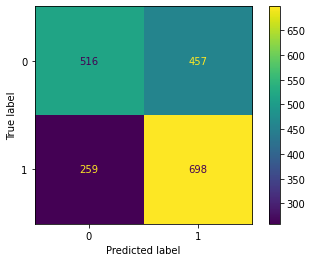

In [46]:
X_gs_tv_gb.plot_confusion_matrix(X_new, y_new)

## Bagging Classifier Models with `body`
[(back to top)](#Models-with-body) <br />


<h2> (gridsearch) CountVectorizer(), BaggingClassifier() </h2>


In [47]:
gs_cv_bc = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    BaggingClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test cVect Bagging')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [48]:
print(gs_cv_bc.model.best_score_)
print(gs_cv_bc.model.best_estimator_)

0.6626473377336701
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('baggingclassifier', BaggingClassifier())])


In [49]:
X_gs_cv_bc = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    BaggingClassifier()), 
    X, X_new, y, y_new,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new cVect Bagging')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [50]:
print(X_gs_cv_bc.model.best_score_)
print(X_gs_cv_bc.model.best_estimator_)

0.6596433440964595
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('baggingclassifier', BaggingClassifier())])


<h2> (gridsearch) TfidfVectorizer(), BaggingClassifier() </h2>


In [51]:
gs_tv_bc = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    BaggingClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf Bagging')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [52]:
print(gs_tv_bc.model.best_score_)
print(gs_tv_bc.model.best_estimator_)

0.656618062662548
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('baggingclassifier', BaggingClassifier())])


In [53]:
X_gs_tv_bc = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    BaggingClassifier()), 
    X, X_new, y, y_new,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new Tfidf Bagging')
X_gs_tv_bc.df

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,Xy/new Tfidf Bagging
F1 Score,0.610572
Recall Score,0.591432
Accuracy,0.625907
Balanced Accuracy,0.625623
Precision Score,0.630992
Average Precision Score,0.648570
ROC AUC Score,0.692174
True Positive,642.000000
False Negative,331.000000
False Positive,391.000000


In [54]:
print(X_gs_tv_bc.model.best_score_)
print(X_gs_tv_bc.model.best_estimator_)

0.6568674182379828
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('baggingclassifier', BaggingClassifier())])


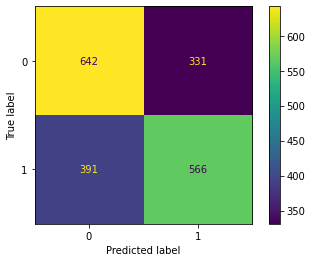

In [72]:
plot_confusion_matrix(X_gs_tv_bc.model, X_new, y_new)

In [55]:
compare_bag = pd.concat([gs_cv_bc.df, X_gs_cv_bc.df, gs_tv_bc.df, X_gs_tv_bc.df], axis=1)
compare_bag

,Train/Test cVect Bagging,Xy/new cVect Bagging,Train/Test Tfidf Bagging,Xy/new Tfidf Bagging
F1 Score,0.636167,0.618815,0.645134,0.610572
Recall Score,0.606584,0.594566,0.616461,0.591432
Accuracy,0.653514,0.636788,0.661323,0.625907
Balanced Accuracy,0.653456,0.636440,0.661268,0.625623
Precision Score,0.668784,0.645125,0.676603,0.630992
Average Precision Score,0.690129,0.666407,0.697835,0.648570
ROC AUC Score,0.723876,0.708340,0.728412,0.692174
True Positive,853.000000,660.000000,860.000000,642.000000
False Negative,365.000000,313.000000,358.000000,331.000000
False Positive,478.000000,388.000000,466.000000,391.000000


## Ada Boosting Models with `body`
[(back to top)](#Models-with-body) <br />


<h2> (gridsearch) CountVectorizer(), AdaBoostClassifier() </h2>


In [56]:
gs_cv_ab = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    AdaBoostClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test cVect adaBst')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [57]:
print(gs_cv_ab.model.best_score_)
print(gs_cv_ab.model.best_estimator_)

0.6670302421437089
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('adaboostclassifier', AdaBoostClassifier())])


In [58]:
X_gs_cv_ab = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    AdaBoostClassifier()), 
    X, X_new, y, y_new,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new cVect adaBst')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [59]:
print(X_gs_cv_ab.model.best_score_)
print(X_gs_cv_ab.model.best_estimator_)

0.6660137529421764
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('adaboostclassifier', AdaBoostClassifier())])


<h2> (gridsearch) TfidfVectorizer(), AdaBoostClassifier() </h2>


In [60]:
gs_tv_ab = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    AdaBoostClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf adaBst')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [61]:
print(gs_tv_ab.model.best_score_)
print(gs_tv_ab.model.best_estimator_)

0.6649757292947881
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('adaboostclassifier', AdaBoostClassifier())])


In [62]:
X_gs_tv_ab = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    AdaBoostClassifier()), 
    X, X_new, y, y_new,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new Tfidf adaBst')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [63]:
print(X_gs_tv_ab.model.best_score_)
print(X_gs_tv_ab.model.best_estimator_)

0.6657053753871216
Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
                ('adaboostclassifier', AdaBoostClassifier())])


In [64]:
compare_ab = pd.concat([gs_cv_ab.df, X_gs_cv_ab.df, gs_tv_ab.df, X_gs_tv_ab.df], axis=1)
compare_ab

,Train/Test cVect adaBst,Xy/new cVect adaBst,Train/Test Tfidf adaBst,Xy/new Tfidf adaBst
F1 Score,0.719708,0.667905,0.715782,0.647233
Recall Score,0.811523,0.751306,0.787654,0.684431
Accuracy,0.684340,0.629534,0.687628,0.630052
Balanced Accuracy,0.684497,0.630535,0.687752,0.630499
Precision Score,0.646557,0.601171,0.655929,0.613871
Average Precision Score,0.699254,0.602213,0.696905,0.625227
ROC AUC Score,0.738792,0.651219,0.737111,0.663331
True Positive,679.000000,496.000000,716.000000,561.000000
False Negative,539.000000,477.000000,502.000000,412.000000
False Positive,229.000000,238.000000,258.000000,302.000000


## Compare Models with `body`
[(back to top)](#Models-with-body) <br />


In [65]:
compare_rfc

,Train/Test cVect RFC,Xy/new cVect RFC,Train/Test Tfidf RFC,Xy/new Tfidf RFC
F1 Score,0.693153,0.653424,0.698636,0.668405
Recall Score,0.674897,0.653083,0.695473,0.669801
Accuracy,0.701603,0.656477,0.700370,0.670466
Balanced Accuracy,0.701570,0.656449,0.700364,0.670461
Precision Score,0.712424,0.653766,0.701827,0.667014
Average Precision Score,0.746449,0.682756,0.745704,0.686959
ROC AUC Score,0.764548,0.730559,0.768110,0.736399
True Positive,887.000000,642.000000,859.000000,653.000000
False Negative,331.000000,331.000000,359.000000,320.000000
False Positive,395.000000,332.000000,370.000000,316.000000


In [66]:
compare_tree

,Train/Test cVect DTree,Xy/new cVect DTree,Train/Test Tfidf DTree,Xy/new Tfidf DTree
F1 Score,0.631623,0.610702,0.658094,0.634424
Recall Score,0.627984,0.649948,0.716049,0.699060
Accuracy,0.634196,0.589119,0.628442,0.600518
Balanced Accuracy,0.634189,0.589619,0.628550,0.601328
Precision Score,0.635304,0.575926,0.608817,0.580729
Average Precision Score,0.581439,0.567352,0.567674,0.573290
ROC AUC Score,0.632949,0.601169,0.618208,0.615436
True Positive,780.000000,515.000000,659.000000,490.000000
False Negative,438.000000,458.000000,559.000000,483.000000
False Positive,452.000000,335.000000,345.000000,288.000000


In [67]:
compare_gb

,Train/Test cVect gBoost,Xy/new cVect gBoost,Train/Test Tfidf gBoost,Xy/new Tfidf gBoost
F1 Score,0.710395,0.663217,0.710908,0.660985
Recall Score,0.762140,0.736677,0.767078,0.729363
Accuracy,0.689684,0.629016,0.688450,0.629016
Balanced Accuracy,0.689773,0.629901,0.688547,0.629841
Precision Score,0.665230,0.603080,0.662402,0.604329
Average Precision Score,0.723648,0.626905,0.732548,0.645076
ROC AUC Score,0.750363,0.673741,0.758687,0.688640
True Positive,752.000000,509.000000,743.000000,516.000000
False Negative,466.000000,464.000000,475.000000,457.000000
False Positive,289.000000,252.000000,283.000000,259.000000


In [68]:
compare_bag

,Train/Test cVect Bagging,Xy/new cVect Bagging,Train/Test Tfidf Bagging,Xy/new Tfidf Bagging
F1 Score,0.636167,0.618815,0.645134,0.610572
Recall Score,0.606584,0.594566,0.616461,0.591432
Accuracy,0.653514,0.636788,0.661323,0.625907
Balanced Accuracy,0.653456,0.636440,0.661268,0.625623
Precision Score,0.668784,0.645125,0.676603,0.630992
Average Precision Score,0.690129,0.666407,0.697835,0.648570
ROC AUC Score,0.723876,0.708340,0.728412,0.692174
True Positive,853.000000,660.000000,860.000000,642.000000
False Negative,365.000000,313.000000,358.000000,331.000000
False Positive,478.000000,388.000000,466.000000,391.000000


In [69]:
compare_lgr

,Train/Test cVect LogReg,Xy/new cVect LogReg,Train/Test Tfidf LogReg,Xy/new Tfidf LogReg
F1 Score,0.724341,0.650980,0.724428,0.679302
Recall Score,0.758025,0.693835,0.743210,0.711599
Accuracy,0.711878,0.631088,0.717633,0.666839
Balanced Accuracy,0.711935,0.631604,0.717664,0.667207
Precision Score,0.693524,0.613112,0.706573,0.649809
Average Precision Score,0.757351,0.664860,0.790564,0.707293
ROC AUC Score,0.780030,0.696882,0.798083,0.735097
True Positive,811.000000,554.000000,843.000000,606.000000
False Negative,407.000000,419.000000,375.000000,367.000000
False Positive,294.000000,293.000000,312.000000,276.000000


In [70]:
compare_ab

,Train/Test cVect adaBst,Xy/new cVect adaBst,Train/Test Tfidf adaBst,Xy/new Tfidf adaBst
F1 Score,0.719708,0.667905,0.715782,0.647233
Recall Score,0.811523,0.751306,0.787654,0.684431
Accuracy,0.684340,0.629534,0.687628,0.630052
Balanced Accuracy,0.684497,0.630535,0.687752,0.630499
Precision Score,0.646557,0.601171,0.655929,0.613871
Average Precision Score,0.699254,0.602213,0.696905,0.625227
ROC AUC Score,0.738792,0.651219,0.737111,0.663331
True Positive,679.000000,496.000000,716.000000,561.000000
False Negative,539.000000,477.000000,502.000000,412.000000
False Positive,229.000000,238.000000,258.000000,302.000000
